Generate spherical grid...
start render...
Procesando frame 720/720
Creando GIF...


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%05d.png':
  D

GIF creado: period_1.0 d_points90000_obs1.0 d_cadence2.0 min_nspots3.gif
Generating ligthcurve..


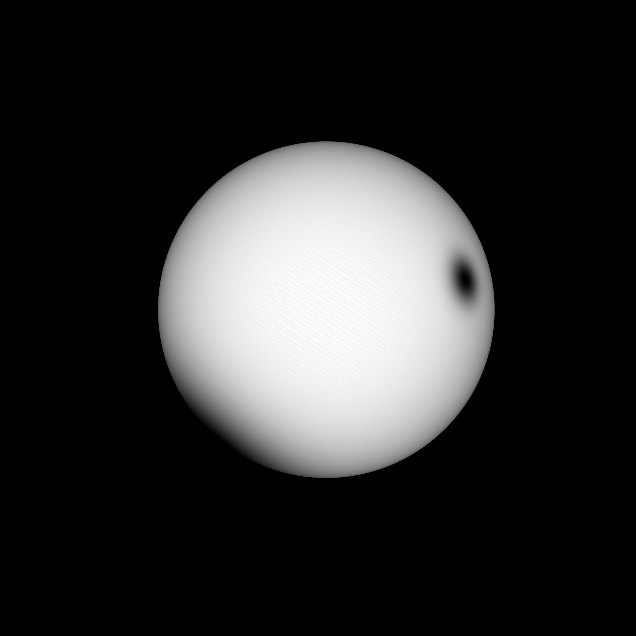

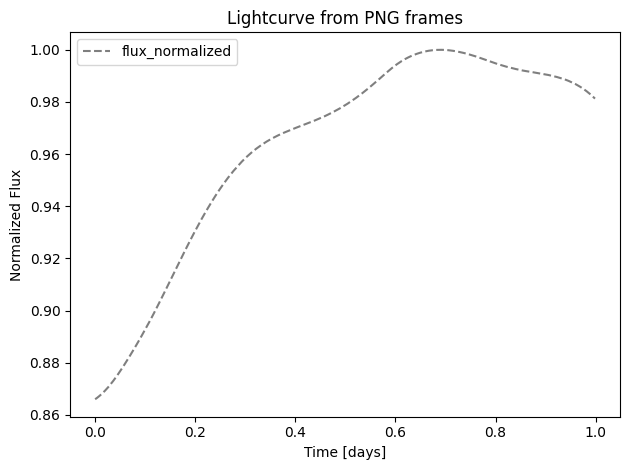

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
import os
from PIL import Image
import glob
import subprocess
import matplotlib as mpl
import gc
import matplotlib


os.makedirs("frames", exist_ok=True)

# ---- fibonacci sphere ----
def fibonacci_sphere(n_points):
    """generating equal points to distributing in sphere"""
    indices = np.arange(n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_points)  # [0, π]
    theta = np.pi * (1 + 5**0.5) * indices  # aureo angle
    
    return phi, theta % (2*np.pi)  # etting values between 0 and 2π

def cartesian_from_spherical(phi, theta, r=1.0):
    """Convert spherical coordinates to cartesians"""
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return x, y, z

def spot_mask_geodesic(x, y, z, spot_center, spot_radius_rad):
    """Máscara usando distancia geodésica real con optimización"""
    # Convert the spot_center vector to a unit vector (of length 1).
    center_norm = spot_center / np.linalg.norm(spot_center)
    
    # Product
    positions = np.stack([x, y, z], axis=-1)
    norms = np.linalg.norm(positions, axis=-1, keepdims=True)
    pos_norm = positions / np.clip(norms, 1e-10, None)  #np.clip avoids division by zero (if a vector had length 0).
    
    dot_product = np.sum(pos_norm * center_norm, axis=-1) #Calculation of the Product Point
    dot_product = np.clip(dot_product, -1, 1) #Force the values to be between [-1, 1]. This is necessary because numerical errors may produce values slightly outside this range.
    
    # central_angle is the geodesic distance (in radians) between each point on the surface and the center of the spot.
    central_angle = np.arccos(dot_product)
    
    return np.exp(-(central_angle**2) / (2 * spot_radius_rad**2))

#function to calculate angular velocity  
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    ''' Parameters:
    - rotation_period: rotation period of the sta
    - spot_colatitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity. '''
    
    latitude = np.pi / 2 - spot_colatitude
    angular_vel_equa = 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity

def limbdarkening(u, mu):
    ''' lineal limb darkening'''
    return (1 - u * (1 - mu))

def quadratic(u1, u2, mu):
    return 1-u1*(1-mu)-u2*(1-mu)**2
    

def add_spots(latitude_deg, longitude_deg, radii_deg):
    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.4)  
    spots.append({
        'theta': longitude_rad * u.rad,
        'phi': colatitude_rad,
        'radius': radii_rad,
        'angular_velocity': ang_vel
    })

def gif(input_pattern="frames/frame_%05d.png", output_gif="output.gif", 
        palette="palette.png", framerate=17):
    palette_cmd = [
        "ffmpeg", "-y", "-i", input_pattern,
        "-vf", "palettegen", palette
    ]
    gif_cmd = [
        "ffmpeg", "-y", "-framerate", str(framerate),
        "-i", input_pattern, "-i", palette,
        "-lavfi", "paletteuse", output_gif
    ]
    try:
        subprocess.run(palette_cmd, check=True)
        subprocess.run(gif_cmd, check=True)
        print(f"GIF creado: {output_gif}")
    except subprocess.CalledProcessError as e:
        print("Error en ffmpeg:", e)

def flux_plot():
    '''
    Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot 

    '''
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    #flux_norm.append(flux_total / fluxes[i])
    flux_norm = normalize([fluxes], norm="max")[0]
    #flux_norm = np.array(fluxes)/np.max(np.array(fluxes))
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv(f"period_{rotation_period}_points{n_points}_obs{observing_baseline_days}_cadence{cadence_time}.csv", index=False)

    # plotting
    
    ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="k")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Lightcurve from PNG frames")
    plt.style.use('default')
    plt.tight_layout()
    plt.savefig(f"period_{rotation_period}_days_points{n_points}_obs{observing_baseline_days}_cadence{cadence_time}.png", dpi=600)
    plt.show()

# ---- Función de animación corregida ----
def animate(i, points, base_intensity, ax_sphere, elev, azim, total_frames, vmin, vmax):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    
    # copying the texture

    intensity = np.copy(base_intensity)
    
    # adding several spots
    for spot in spots:
        # Calcular nueva posición de la mancha
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        
        # Calculating position of the spot
        spot_x = r_val * np.sin(spot['phi']) * np.cos(theta_mov.value)
        spot_y = r_val * np.sin(spot['phi']) * np.sin(theta_mov.value)
        spot_z = r_val * np.cos(spot['phi'])
        spot_center = np.array([spot_x, spot_y, spot_z])
        
        # creating a mask
        mask = spot_mask_geodesic(points[:, 0], points[:, 1], points[:, 2], 
                                 spot_center, spot['radius'])
        intensity *= (1 -  mask)  # Reducción de intensidad en manchas
    
    # scatter plot 
    sc = ax_sphere.scatter(
        points[:, 0], points[:, 1], points[:, 2], 
        #c=intensity,
        c=np.clip(intensity, 0, 1),
        cmap='gray', 
        s=1, 
        alpha=1,
        vmin=0,  # Mínimo fijo
        vmax=1.0   # Máximo fijo
    )
    
    # Configurar límites de la esfera
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)
    
    print(f"Procesando frame {i+1}/{total_frames}", end='\r')
    plt.savefig(f"frames/frame_{i:05d}.png", dpi=300, bbox_inches='tight')
    
    return None

# ---- main ----
if __name__ == '__main__':
    # stellar parameter
    r_val = 1.0
    n_points = 90000
    u1 = 0.4
    u2 =0.3# limb darkening coefficients
    rotation_period = 1.0 * u.day
    
    # Point of view
    elev = 0
    azim = 0
    
    # List of spots
    spots = []
    
    #adding spots
    add_spots(10, 60, 5.5)      
    add_spots(-50, 0, 20.5)     
    #add_spots(0, 0, 20)  
    add_spots(50, 240, 10.5) 
    
    # base lines time parameter
    observing_baseline_days = 1 * u.day
    cadence_time = 2 * u.minute
    total_frames = int((observing_baseline_days / cadence_time).decompose().value)
    
    # spherical grid with fibonacci points
    print("Generate spherical grid...")
    phi, theta = fibonacci_sphere(n_points)
    x, y, z = cartesian_from_spherical(phi, theta)
    points = np.vstack([x, y, z]).T
    
    # Calculate point of view
    elev_rad = np.deg2rad(elev) #elevation of point of view
    azim_rad = np.deg2rad(azim)#azimut of point of view
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # rearrange of calculating mu parameter for limb darkening
    mu = (points[:, 0] * v_x + points[:, 1] * v_y + points[:, 2] * v_z) / r_val
    mu = np.clip(mu, 0, 1)
    #base_intensity = limbdarkening(constant, mu)# applying to the texture
    base_intensity = quadratic(u1,u2,mu) 
    #    Calculates the extreme values of the base intensity: 
    #vmin: Minimum value of intensity in the whole star.
    #vmax: Maximum value of intensity over the whole star.
    vmin=  0.0
    vmax=  1.0

   # Defines a reference range for color mapping that will be used consistently across all frames.
 
    
    # background configurations
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 8))
    ax_sphere = fig.add_subplot(111, projection='3d') 
    ax_sphere.set_axis_off()
    ax_sphere.set_box_aspect([1, 1, 1])
    
    #Límits
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)
    
    # Generating animation
    print("start render...")
    for i in range(total_frames):
        animate(i, points, base_intensity, ax_sphere,  elev, azim, total_frames, vmin, vmax)

    
    # Create gif an light curve
    print("\nCreando GIF...")
    gif(input_pattern="frames/frame_%05d.png", output_gif=f"period_{rotation_period}_points{n_points}_obs{observing_baseline_days}_cadence{cadence_time}_nspots{len(spots)}.gif", framerate=15)
    print("Generating ligthcurve..")
    plt.style.use('default')
    flux_plot()



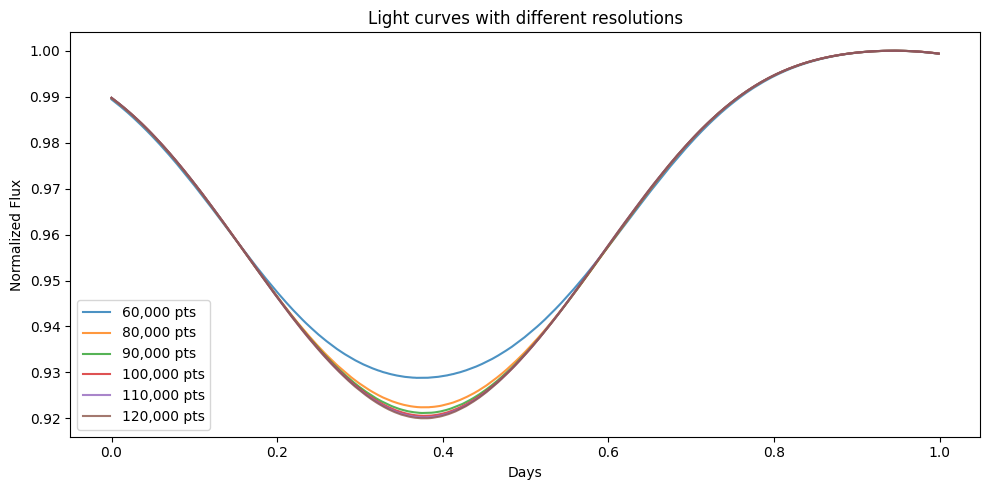

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los archivos
df_60000 = pd.read_csv("period_1.0 d_points60000_obs1.0 d_cadence2.0 min.csv")
df_80000 = pd.read_csv("period_1.0 d_points80000_obs1.0 d_cadence2.0 min.csv")
df_90000 = pd.read_csv("period_1.0 d_points90000_obs1.0 d_cadence2.0 min.csv")
df_100000 = pd.read_csv("period_1.0 d_points100000_obs1.0 d_cadence2.0 min.csv")
df_110000 = pd.read_csv("period_1.0 d_points110000_obs1.0 d_cadence2.0 min.csv")
df_120000 = pd.read_csv("period_1.0 d_points120000_obs1.0 d_cadence2.0 min.csv")

# Crear la figura
plt.figure(figsize=(10, 5))

# Graficar cada curva
plt.plot(df_60000["Days"], df_60000["flux_normalized"], label="60,000 pts", alpha=0.8)
plt.plot(df_80000["Days"], df_80000["flux_normalized"], label="80,000 pts", alpha=0.8)
plt.plot(df_90000["Days"], df_90000["flux_normalized"], label="90,000 pts", alpha=0.8)
plt.plot(df_100000["Days"], df_100000["flux_normalized"], label="100,000 pts", alpha=0.8)
plt.plot(df_110000["Days"], df_110000["flux_normalized"], label="110,000 pts", alpha=0.8)
plt.plot(df_120000["Days"], df_120000["flux_normalized"], label="120,000 pts", alpha=0.8)

# Estética
plt.xlabel("Days")
plt.ylabel("Normalized Flux")
plt.title("Light curves with different resolutions")
plt.legend()
plt.tight_layout()
plt.savefig("light_curve_comparison_resolutions.png", dpi=600)
plt.show()


Comparación de curvas de luz por MSE:
period_1.0 d_points60000_obs1.0 d_cadence2.0 min.csv (60000 pts): MSE = 1.327414e-05
period_1.0 d_points80000_obs1.0 d_cadence2.0 min.csv (80000 pts): MSE = 9.065410e-07
period_1.0 d_points90000_obs1.0 d_cadence2.0 min.csv (90000 pts): MSE = 2.330664e-07
period_1.0 d_points100000_obs1.0 d_cadence2.0 min.csv (100000 pts): MSE = 6.891287e-08
period_1.0 d_points110000_obs1.0 d_cadence2.0 min.csv (110000 pts): MSE = 2.142490e-08
period_1.0 d_points120000_obs1.0 d_cadence2.0 min.csv (120000 pts): MSE = 4.254647e-09
period_1.0 d_points130000_obs1.0 d_cadence2.0 min.csv (130000 pts): MSE = 0.000000e+00


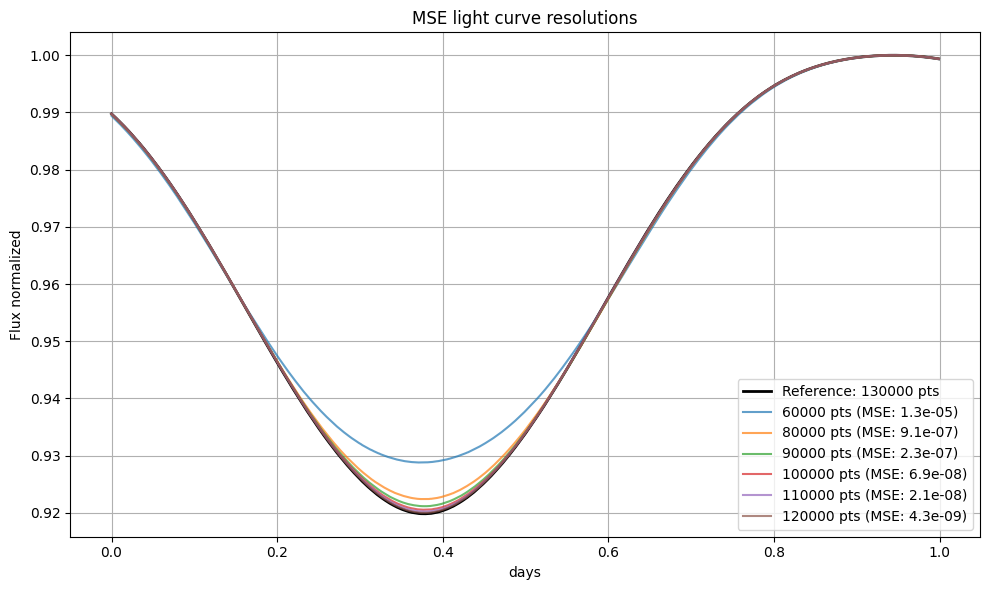

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
from sklearn.metrics import mean_squared_error

# Ruta de tus archivos
ruta_archivos = "./lightcurvecsv/"
archivos_csv = sorted(glob.glob(ruta_archivos + "*.csv"))

# Extraer resolución del nombre del archivo
def extraer_resolucion(nombre_archivo):
    match = re.search(r'points(\d+)', nombre_archivo)
    return int(match.group(1)) if match else 0

# Cargar curvas de luz
curvas = []
for archivo in archivos_csv:
    df = pd.read_csv(archivo)
    curvas.append({
        "nombre": archivo.split("/")[-1],
        "resolucion": extraer_resolucion(archivo),
        "time": df["time"].values if "time" in df.columns else df["Days"].values,
        "flux": df["flux"].values if "flux" in df.columns else df["flux_normalized"].values
    })

# Seleccionar curva de mayor resolución como referencia
curva_ref = max(curvas, key=lambda c: c["resolucion"])
t_ref = curva_ref["time"]
f_ref = curva_ref["flux"]

# Comparar y calcular MSE
mse_resultados = []
for curva in curvas:
    if not np.array_equal(curva["time"], t_ref):
        f_interp = np.interp(t_ref, curva["time"], curva["flux"])
    else:
        f_interp = curva["flux"]

    mse = mean_squared_error(f_ref, f_interp)
    mse_resultados.append({
        "nombre": curva["nombre"],
        "resolucion": curva["resolucion"],
        "mse": mse,
        "flux_interp": f_interp
    })

# Ordenar por resolución (o por MSE si prefieres)
mse_resultados.sort(key=lambda x: x["resolucion"])

# Mostrar resultados en consola
print("Comparación de curvas de luz por MSE:")
for res in mse_resultados:
    print(f"{res['nombre']} ({res['resolucion']} pts): MSE = {res['mse']:.6e}")

# Graficar todas las curvas
plt.figure(figsize=(10, 6))
plt.plot(t_ref, f_ref, label=f"Reference: {curva_ref['resolucion']} pts", linewidth=2, color='black')

for res in mse_resultados:
    if res["nombre"] != curva_ref["nombre"]:
        plt.plot(t_ref, res["flux_interp"], 
                 label=f"{res['resolucion']} pts (MSE: {res['mse']:.1e})", alpha=0.7)

plt.xlabel("days")
plt.ylabel("Flux normalized")
plt.title("MSE light curve resolutions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Resolution_Comparison.png", dpi=600)
plt.show()


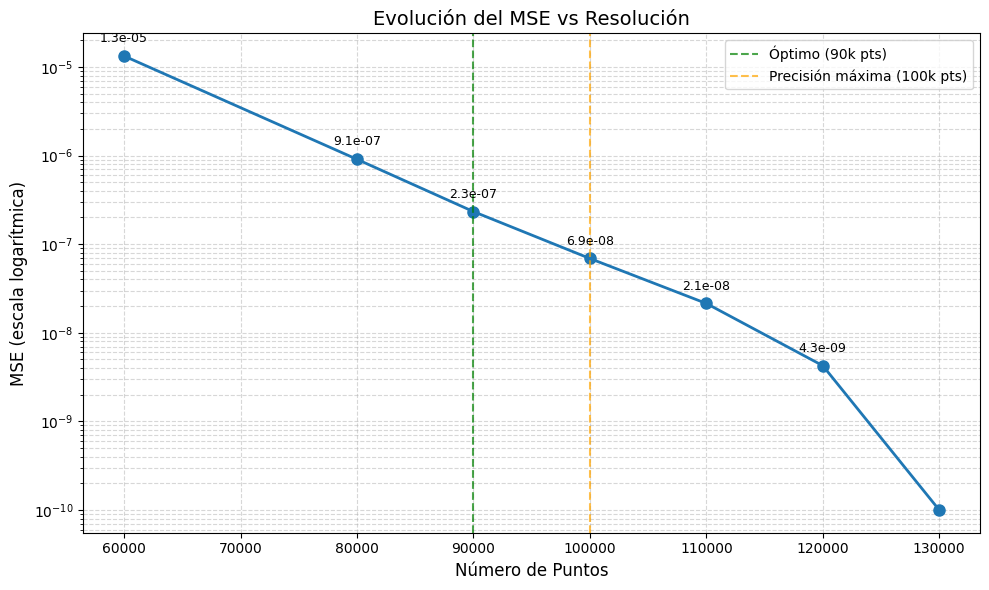

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Tus datos
resoluciones = [60000, 80000, 90000, 100000, 110000, 120000, 130000]
mse_values = [1.327414e-05, 9.065410e-07, 2.330664e-07, 
              6.891287e-08, 2.142490e-08, 4.254647e-09, 0]

# Convertir MSE=0 a un valor pequeño para escala log
mse_for_plot = [m if m > 0 else 1e-10 for m in mse_values]

plt.figure(figsize=(10, 6))
plt.semilogy(resoluciones, mse_for_plot, 'o-', markersize=8, linewidth=2)

# Líneas de referencia
plt.axvline(90000, color='g', linestyle='--', alpha=0.7, label='Óptimo (90k pts)')
plt.axvline(100000, color='orange', linestyle='--', alpha=0.7, label='Precisión máxima (100k pts)')

# Ajustes estéticos
plt.title('Evolución del MSE vs Resolución', fontsize=14)
plt.xlabel('Número de Puntos', fontsize=12)
plt.ylabel('MSE (escala logarítmica)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

# Anotar valores
for i, (res, mse) in enumerate(zip(resoluciones, mse_values)):
    if mse > 0:
        plt.annotate(f'{mse:.1e}', (res, mse_for_plot[i]), 
                     xytext=(0, 10), textcoords='offset points',
                     ha='center', fontsize=9)

plt.savefig('mse_vs_resolution.png', dpi=300)
plt.show()

In [53]:
len(curvas[0]["time"])

720

720